In [3]:
!pip install numpyro dill termcolor torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [15]:
!pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

/opt/tljh/user/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 10.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import jax
print(jax.devices())

[CudaDevice(id=0), CudaDevice(id=1)]


In [5]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import torch

from termcolor import colored

import dill
import pickle

In [3]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

def check_tensor_cuda(t):
    assert isinstance(x, torch.Tensor) and x.is_cuda, colored("Var not a torch tensor or not using cuda","red")

#GP Kernel Function

In [11]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [12]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


#Aggregation Functions

In [13]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

#Aggregated Prevalence Model - must edit this to include HDI, population density



In [14]:
def prev_model_gp_aggr(args, total_cases=None, total_population=None):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    pop_density = args["pop_density"]  # (num_districts,)
    hdi = args["hdi"]  # (num_districts,)
    M = args["M"]  # (num_districts, num_grid_points) aggregation matrix

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr = numpyro.deterministic("gp_aggr", M @ f)  # (num_districts,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))  # (num_districts,)

    # Binomial likelihood
    observed_cases = numpyro.sample(
        "observed_cases",
        dist.Binomial(total_count=total_population, probs=theta),
        obs=total_cases
    )

    return observed_cases


#Load Data

In [15]:
# Lat/Lon Values of artificial grid
x = np.load("lat_lon_x_all.npy")

# combined regional data
pol_pts_all = np.load("pol_pts_all.npy")
pt_which_pol_all = np.load("pt_which_pol_all.npy")

#combine the dataframes
df_combined = gpd.read_file("final_combined_divisions.shp")

In [16]:
#check columns
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_densit,geometry
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [10]:
#rename Pop_densit to Pop_density
df_combined = df_combined.rename(columns={'Pop_densit': 'Pop_density'})

#check head again
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_density,geometry
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


#Vars needed to be changed (change according to the agg prevalence model parameters)

In [11]:
M = jnp.array(pol_pts_all)
pop_density = jnp.array(df_combined["Pop_density"])
hdi = jnp.array(df_combined["HDI"])
test_cases = jnp.array(df_combined["Population"])
cases = jnp.array(df_combined["Cases"])

In [12]:
#print the shape of all the vars above
print(M.shape)
print(pop_density.shape)
print(hdi.shape)
print(test_cases.shape)
print(cases.shape)
print(x.shape)
print(pt_which_pol_all.shape)

(96, 7304)
(96,)
(96,)
(96,)
(96,)
(7304, 2)
(7304,)


#Agg GP Model

In [13]:
 args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M" : M, # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3,3), #(,)
        "kernel_var" : dist.HalfNormal(0.05),
        "pop_density": jnp.array(pop_density), # Shape (num_districts,)
        "hdi": jnp.array(hdi), # Shape (num_districts, 2)
    }


#Run MCMC

In [14]:
run_key, predict_key = random.split(random.PRNGKey(3))
n_warm = 500
n_samples = 500
mcmc = MCMC(
        NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples = n_samples
    )


In [15]:
start = time.time()
mcmc.run(run_key, args, total_cases = jnp.array(cases), total_population = jnp.array(test_cases))
end = time.time()
t_elapsed_min = round((end - start)/60)

print(f"Time taken for aggGP : {t_elapsed_min}'min")

sample: 100%|██████████| 1000/1000 [10:22:06<00:00, 37.33s/it, 337 steps of size 3.34e-06. acc. prob=0.89]   

Time taken for aggGP : 622'min


#Save Model

In [16]:
import os
import dill

# Define the file path
f_path = f"model_weights/aggGP_nsamples_{n_samples}_tt{t_elapsed_min}min"

# Ensure the directory exists
os.makedirs(os.path.dirname(f_path), exist_ok=True)

# Save the model
with open(f_path, 'wb') as file:
    dill.dump(mcmc, file)

# Print elapsed time
print("\nMCMC elapsed time:", round(end), "s")
print("\nMCMC elapsed time:", round(end/60), "min")
print("\nMCMC elapsed time:", round(end/(60*60)), "h")


MCMC elapsed time: 1741311104 s

MCMC elapsed time: 29021852 min

MCMC elapsed time: 483698 h


In [18]:
#print the agnostics
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))
print("Max r_hat for all aggGP effects : " + str(round(np.max(ss['gp_aggr']['r_hat']),2)))

print("kernel_length R-hat : " + str(round(ss['kernel_length']['r_hat'],2)))
print("kernel_var R-hat : " + str(round(ss['kernel_var']['r_hat'],2)))

Average ESS for all aggGP effects : 5
Max r_hat for all aggGP effects : 3.2
kernel_length R-hat : 1.0
kernel_var R-hat : nan


In [6]:
#check whether 500 samples are sufficient to achieve convergence
with open("model_weights/aggGP_nsamples_500_tt622min", 'rb') as file:
    mcmc = dill.load(file)

In [7]:
pos_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic = False)

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True))
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")
print(f"Max r_hat for all aggGP effects : {str(round(np.max(ss['gp_aggr']['r_hat']),2))}")
print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0      1.97      0.00      1.97      1.97      1.97      1.00      1.00
          b_hdi     -1.75      0.00     -1.75     -1.75     -1.75      3.77      1.65
  b_pop_density      0.46      0.00      0.46      0.45      0.46      2.87      2.64
           f[0]      0.78      0.00      0.78      0.78      0.78      6.71      1.03
           f[1]     -0.16      0.00     -0.16     -0.16     -0.16      4.04      1.66
           f[2]      1.67      0.00      1.67      1.67      1.67      1.00      1.00
           f[3]     -0.49      0.00     -0.49     -0.49     -0.49      5.28      1.50
           f[4]     -1.21      0.00     -1.21     -1.21     -1.21      1.00      1.00
           f[5]     -1.59      0.00     -1.59     -1.59     -1.59      2.49      1.85
           f[6]      1.62      0.00      1.62      1.62      1.62      1.13      2.09
           f[7]     -0.89      0.00     -0.89     -0.

In [9]:
!pip install arviz

/opt/tljh/user/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 11.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


/home/jupyter-jwidyawati/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


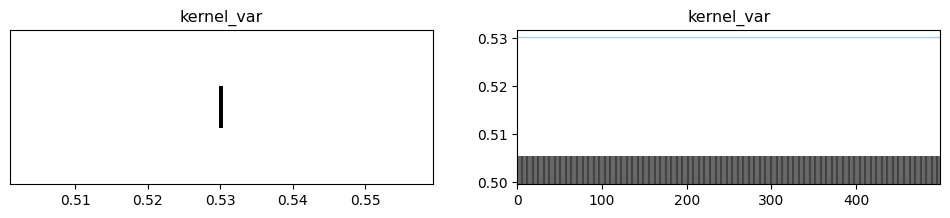

In [17]:
import arviz as az
import matplotlib.pyplot as plt

# Convert samples into an ArviZ InferenceData object
idata = az.from_numpyro(mcmc)

# Trace plot for kernel_var
az.plot_trace(idata, var_names=["kernel_var"])
plt.show()